## Credit Card Fraud Detection

In this notebook, we will be analyzing the dataset that contains transactions made by credit cards in September 2013 by European cardholders, where we have 492 frauds out of 284,807 transactions. This is a fun dataset for analysis, as it is tightly related to our daily life. Most people have experience in receiving email/text from the bank to confirm if the transaction is actually conducted by the credit card owner or not. Sometime it captures fraud transactions, most of the time it works as a confirmation just for safety. 

In machine learning/statistics term, such emails/texts are often "false positive", they might be bad in terms of predictions, but in real life, such misclassifications are totally tolerable. The ones we want to eliminate are "false negative" misclassifications, where we predict a fraud transaction to be normal transaction, which could cause huge financial loss. Therefore for such dataset, we need to re-think about the metrics for model evaluation. We have been using accuracy score throughout this course, but accuracy score provides very minimal value in this case. A simple model that predicts every transaction to be non-fraud can easily achieve 99.83% accuracy, but then we are commiting all possible "false negative" mistakes.

Let's start by doing exploratory data analysis.

### Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

In [2]:
cc_df = pd.read_csv('./creditcard.csv')
print(cc_df.head())
print('-'*100)
print("Columns:", cc_df.columns)
print('-'*100)
print('Labels:', cc_df['Class'].unique())
print('-'*100)
cc_df.info()

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

#### Check for Missing Values

According to dataframe info and `isnull` check, there is no missing value in this dataset, there is no need for imputation.

In [3]:
for col in cc_df.columns:
    assert cc_df[col].isnull().sum() == 0
print("No missing value")

No missing value


#### Check for Duplicate Data

There are duplicate records in the dataset, let's remove them. By default `drop_duplicates` take all columns into consideration when determine if a record is duplicate.

In [4]:
print("Total number of records:", len(cc_df))
print("Total number of unique records", len(cc_df.drop_duplicates()))
cc_df = cc_df.drop_duplicates()

Total number of records: 284807
Total number of unique records 283726


#### Imbalance Visualization

Let's visualize how imbalanced the dataset is.

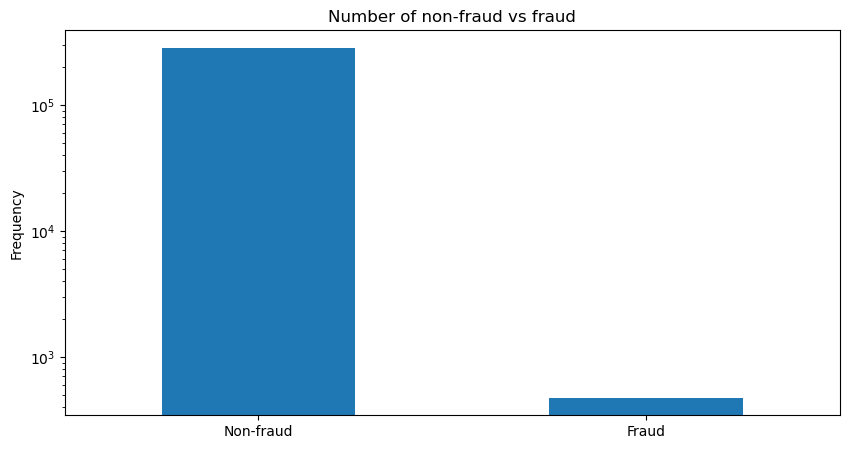

In [5]:
classes = cc_df['Class'].copy()
classes = classes.apply(lambda x: 'Non-fraud' if x == 0 else 'Fraud')
ax = classes.value_counts().plot(kind='bar',figsize=(10,5),title="Number of non-fraud vs fraud")
ax.set_ylabel("Frequency")
plt.xticks(rotation=0)
ax.set_yscale('log')

#### Features Distribution Visualization

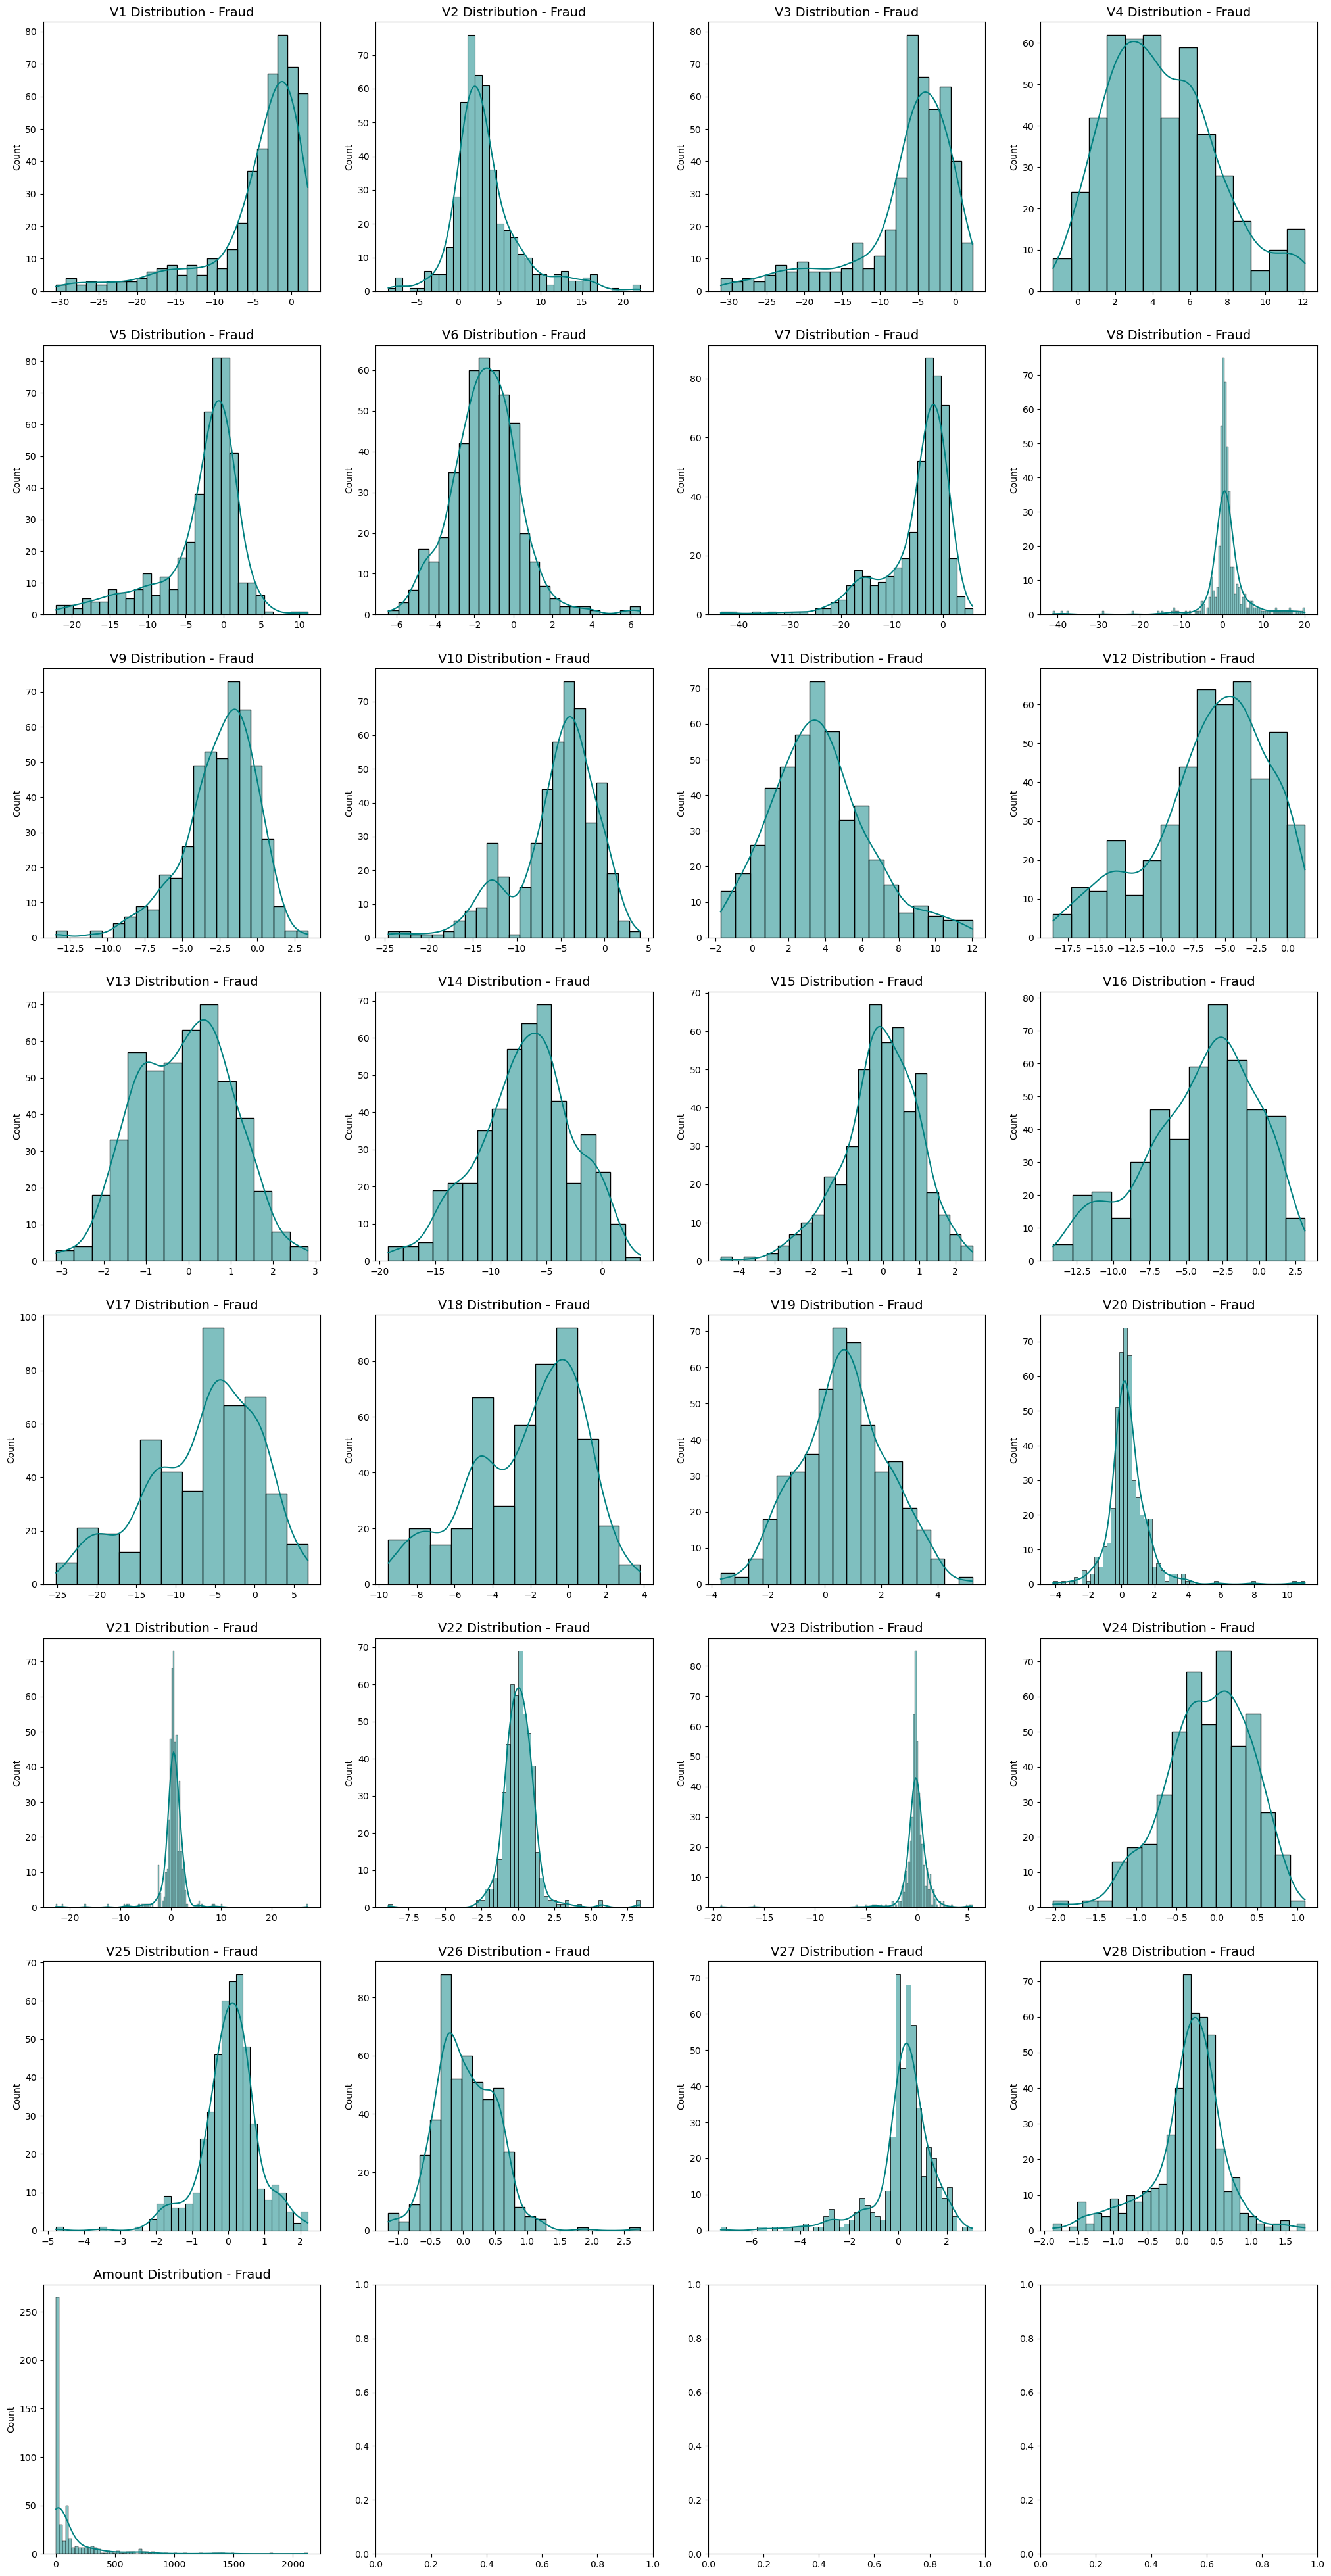

In [6]:
fig, ax = plt.subplots(nrows=8, ncols=4, figsize=(25, 50))
count = 1
for row in ax:
    for col in row:
        column = f'V{count}' if count <= 28 else 'Amount'
        dist = cc_df[column].loc[cc_df['Class'] == 1].values
        sns.histplot(dist, ax=col, kde=True, color='teal')
        col.set_title(f'{column} Distribution - Fraud', fontsize=14)
        if column == 'Amount':
            break
        count += 1

#### Log Transformation on Skewed Features
According to the plots, some features are highly skewed, it's a good practice to apply log transformation on the highly right skewed features. A skewness value greater than 0 indicates right skewness. Values between 0 and 0.5 indicate moderate right skew, and values above 0.5 indicate high right skew.

In [7]:
# Apply log transformation
skewness = cc_df[[i for i in cc_df.columns if i != 'Class']].skew()
high_right_skewed_features = skewness[abs(skewness) > 0.5]
low_right_skewed_features = skewness[abs(skewness) <= 0.5]
print("High Skewed Features:\n", list(high_right_skewed_features.keys()))
print("Low Skewed Features:\n", list(low_right_skewed_features.keys()))

for col in high_right_skewed_features.keys():
    if (cc_df[col] <= 0).any(): # apply log transformation on features that contain negative values
        min_val = cc_df[col].min()
        shift_val = abs(min_val) + 1
        cc_df[col] = np.log(cc_df[col] + shift_val)
    else:
        cc_df[col] = np.log(cc_df[col])

High Skewed Features:
 ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17', 'V20', 'V21', 'V23', 'V24', 'V26', 'V27', 'V28', 'Amount']
Low Skewed Features:
 ['Time', 'V11', 'V13', 'V15', 'V18', 'V19', 'V22', 'V25']


### Model Building

#### Plain Logistic Regression

Since this is binary classification problem, let's start by building a simple logistic regression model and see how is the performance

In [8]:
features = [i for i in cc_df.columns if i != 'Class']
X = cc_df[features]
y = cc_df['Class']

# using 1/3 of the data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

lr = LogisticRegression(solver='liblinear', random_state=42)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

In [9]:
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))

Accuracy: 0.9988


As we discussed, the accuracy looks amazing but is not actually very useful, this model is merely as good as a dummy model that simply predicts every transaction to be non-fraud. Let's use more meaningful metrics like f1 score and ROC-AUC.

F1 score: 0.4
ROC-AUC score: 0.8793


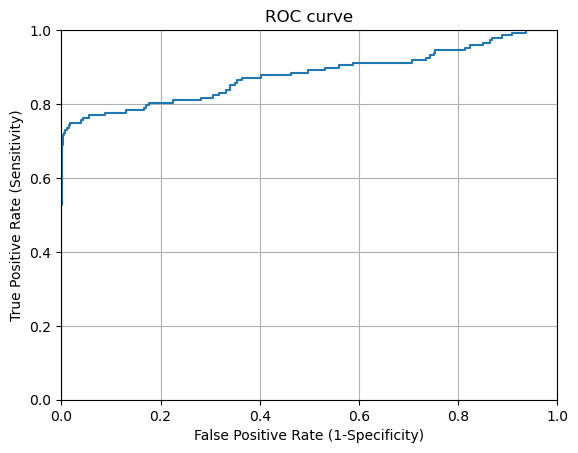

In [10]:
y_prob = lr.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print("F1 score:", round(f1_score(y_test, y_pred), 4))
print("ROC-AUC score:", round(roc_auc_score(y_test,y_prob[:,1]), 4))

With the proper metrics, we can see that the plain logistic regression model performed poorly, with f1 scoring being 0.4, and ROC-AUC score only being 0.88. There should be room for improvement.

#### Logistic Regression with Principal Component Analysis

Principal Component Analysis (PCA) is a technique we leanred in the second course of this specialization. It is a powerful tool for simplifying complex datasets, making them easier to analyze and visualize while preserving important information. Most importantly, it helps reduce dimensionality and noises. Let's apply PCA and find out the features that could explain most of the variances.

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA()
pca.fit(X_train_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

Let's plot the explained variance and show the 90% threshold.

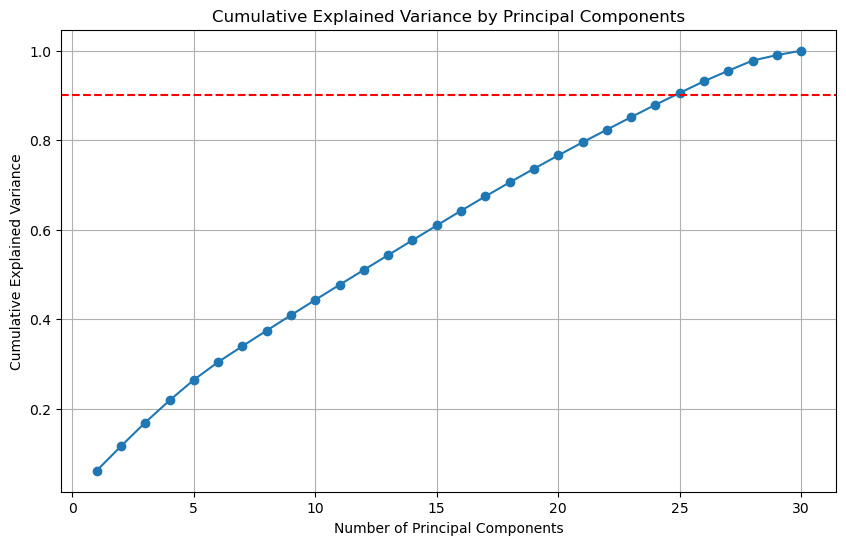

Number of components to explain 90% variance: 25


In [12]:
# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.90, color='r', linestyle='--')  # 90% threshold line
plt.grid()
plt.show()

n_components = np.argmax(cumulative_variance >= 0.9) + 1  # Components to explain 90% variance
print(f"Number of components to explain 90% variance: {n_components}")

pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

F1 score: 0.6234
ROC-AUC score: 0.9602


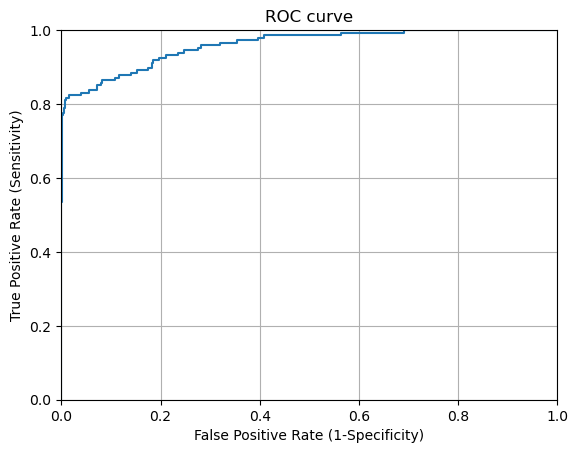

In [13]:
lr.fit(X_train_pca,y_train)
y_pred=lr.predict(X_test_pca)

y_prob = lr.predict_proba(X_test_pca)
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print("F1 score:", round(f1_score(y_test, y_pred), 4))
print("ROC-AUC score:", round(roc_auc_score(y_test,y_prob[:,1]), 4))

### Hyper-parameter Tuning
Now, to additionally improve our model, we can use grid search to find out the best hyper parameters for the model.

*There might be some errors due to invalid combination of parameters when doing grid search, we can ignore them.*

In [14]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=lr, 
                           param_grid=param_grid, 
                           scoring='roc_auc', 
                           cv=3,
                           verbose=1,
                           n_jobs=-1,
                           error_score=0)

# Fit the model
grid_search.fit(X_train_pca, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


C:\Users\chris\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
165 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\chris\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\chris\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\chris\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Valu

Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}


C:\Users\chris\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Based on the grid search result, the best parameters are:

    C: 100
    
    penalty: l2
    
    solver: sag


F1 score: 0.6256
ROC-AUC score: 0.9748


C:\Users\chris\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


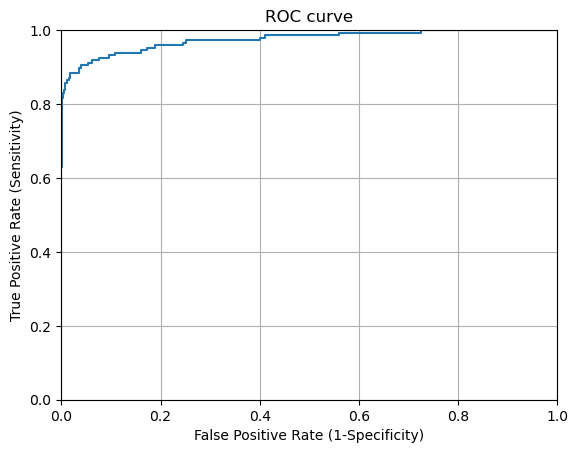

In [15]:
# Build a model with best parameters and see how good it is now
lr = LogisticRegression(C=100, penalty='l2', solver='sag', random_state=42)
lr.fit(X_train_pca,y_train)
y_pred=lr.predict(X_test_pca)

y_prob = lr.predict_proba(X_test_pca)
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print("F1 score:", round(f1_score(y_test, y_pred), 4))
print("ROC-AUC score:", round(roc_auc_score(y_test,y_prob[:,1]), 4))

Not quite a lot, but there are some additional improvements on f1 and ROC-AUC scores.

### Conclusion
In this notebook we analyzed the highly imbalanced dataset for credit card fraud transactions. We started by cleaning the dataset and some exploratory data analysis, then building a logistic regression model for prediction. The performance of the plain model was not very good, and we improved the model throughout PCA and grid search processes.

F1 score improvements:

    0.4 -> 0.6234 -> 0.6256

ROC-AUC score improvements:

    0.8793 -> 0.9602 -> 0.9748

### References

Kaggle Credit Card Fraud Detection: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

Imbalanced dataset: https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets

Principal Component Analysis: https://builtin.com/data-science/step-step-explanation-principal-component-analysis